# Denoising Autoencoders And Where To Find Them

Today we're going to train deep autoencoders and deploy them to faces and search for similar images.

Our new test subjects are human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

# Import stuff

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from lfw_dataset import load_lfw_dataset

# Load dataset
Dataset was downloaded for you. Relevant links (just in case):
- http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
- http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
- http://vis-www.cs.umass.edu/lfw/lfw.tgz

In [2]:
# TODO: download the data

In [3]:
X, attr = load_lfw_dataset(use_raw=True,dimx=38,dimy=38)
X = X.astype('float32') / 255.0

img_shape = X.shape[1:]

X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

('X shape:', (13143, 38, 38, 3))
('attr shape:', (13143, 73))


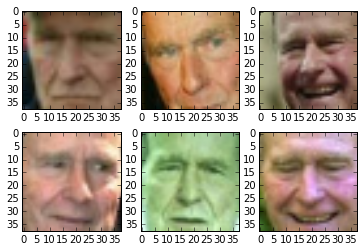

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i])

print("X shape:",X.shape)
print("attr shape:",attr.shape)

### Autoencoder architecture

Let's design autoencoder as two sequential keras models: the encoder and decoder respectively.

We will then use symbolic API to apply and train those models.

<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" width=640px>



In [5]:
import theano
import theano.tensor as T
import lasagne
from lasagne.layers import *

## First step: PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [6]:
from tqdm import tqdm_notebook

In [18]:
losses = [0,1,2]
epoch = 0

In [33]:
t = tqdm_notebook([1,2,3])
t.set_description("asdf")
for x in t:
    print x

1
2
3


In [59]:
from batch_iterator import iterate_minibatches
def build_pca_autoencoder(img_shape, code_size=32):
    class _encoder:
        l_inp = InputLayer((None,) + img_shape)
        input_images = l_inp.input_var
        
        l_flat = flatten(l_inp)
        l_code = DenseLayer(l_flat, code_size, nonlinearity=None)
        
        code = get_output(l_code)
        
        weights = get_all_params(l_code, trainable= True)
        l2 = lasagne.regularization.regularize_network_params(l_code, lasagne.regularization.l2)
        l1 = lasagne.regularization.regularize_network_params(l_code, lasagne.regularization.l1)
        
        encode = theano.function([input_images], code)
        
    class _decoder:
        l_inp = InputLayer((None,code_size))
        l_flat = DenseLayer(l_inp, np.prod(img_shape), nonlinearity= None)
        l_reconstructed = ReshapeLayer(l_flat,(-1,) + img_shape)
        
        reconstructed = get_output(l_reconstructed)
        
        weights = get_all_params(l_reconstructed,trainable= True)
        l2 = lasagne.regularization.regularize_network_params(l_reconstructed, lasagne.regularization.l2)
        l1 = lasagne.regularization.regularize_network_params(l_reconstructed, lasagne.regularization.l1)
        
        decode = theano.function([l_inp.input_var], reconstructed)
    class autoencoder:
        encoder = _encoder
        decoder = _decoder
        # regularization params
        encoder_l2 = theano.shared(0.0,"encoder_l2")
        decoder_l2 = theano.shared(0.0,"decoder_l2")
        # apply
        l_inp = encoder.l_inp
        code = encoder.code
        reconstructed = get_output(decoder.l_reconstructed, {decoder.l_inp: code})
        #fit
        all_weights = encoder.weights + decoder.weights
        regularization = encoder_l2 * encoder.l2 + decoder_l2 * decoder.l2
        
        loss = lasagne.objectives.squared_error(encoder.input_images, reconstructed).mean() + regularization
        updates = lasagne.updates.adamax(loss, all_weights)
        
        _fit = theano.function([encoder.input_images], loss, updates= updates, allow_input_downcast= True)
        predict = theano.function([encoder.input_images], reconstructed)
        
        encode = encoder.encode
        decode = decoder.decode
        
        
        @staticmethod
        def fit(X, batch_size= 32, n_epochs= 1, epochal= None):

            def _epochal(epoch, losses):
                pass
            epochal = epochal or _epochal
            hist = []
            n_batches = np.ceil(X.shape[0] / float(batch_size))
            
            for epoch in xrange(n_epochs):
                loss = []
                
                t = tqdm_notebook(iterate_minibatches(X, batchsize= batch_size, shuffle= True),
                                  total= n_batches)
                
                for x in t:
                    t.set_description('Epoch {0}, mean loss: {1}'.format(epoch, np.mean(loss)))
                    loss.append(autoencoder._fit(x))
                hist.append(np.mean(loss))
                t.set_description('End of Epoch {0}, mean loss: {1}'.format(epoch, hist[-1]))
                epochal(epoch, hist)
        
    return autoencoder

In [60]:
pca = build_pca_autoencoder(img_shape,code_size=32)

In [61]:
pca.fit(X_train,n_epochs=32)

KeyboardInterrupt: 

In [62]:
def visualize(img,autoencoder):
    """Draws original, encoded and decoded images"""
    code = autoencoder.encode(img[None])[0]
    reco = autoencoder.decode(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco.clip(0,1))
    plt.show()


In [63]:
pca.encoder_l2.set_value(0.0)
pca.decoder_l2.set_value(0.0)

In [64]:
pca.fit(X_test, 2000, 1) # TODO: add loss function separated

301/|/Epoch 26, mean loss: 0.00685833739709:  81%|| 301/370.0 [00:20<00:04, 15.04it/s]

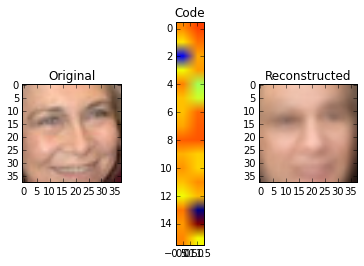

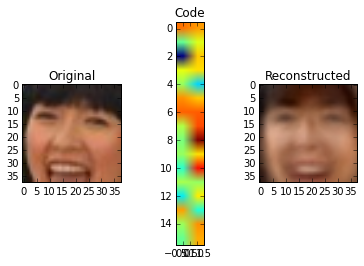

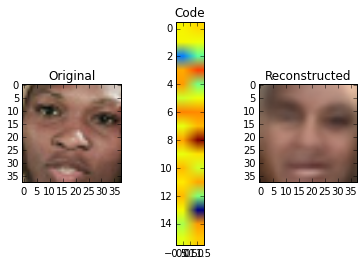

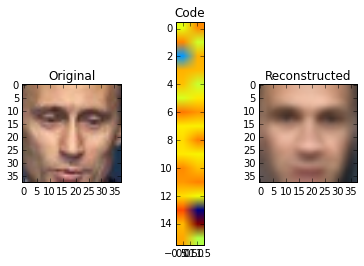

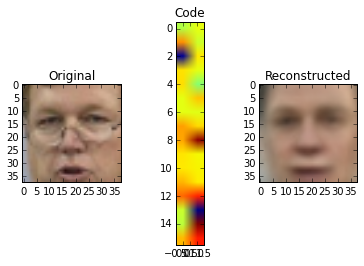

In [65]:
#score = autoencoder.evaluate(X_test,X_test,verbose=0)
#print("Final MSE:",score)

for i in range(5):
    img = X_test[i]
    visualize(img,pca)


### Going deeper

PCA is neat but surely we can do better. This time we want you to build a deep autoencoder by... stacking more layers.

In particular, your encoder and decoder should be at least 3 layers deep each. You can use any nonlinearity you want and any number of hidden units in non-bottleneck layers provided you can actually afford training it.

![layers](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

A few sanity checks:
* There shouldn't be any hidden layer smaller than bottleneck (encoder output).
* Don't forget to insert nonlinearities between intermediate dense layers.
* Convolutional layers are allowed but not required. To undo convolution use L.Deconv2D, pooling - L.UpSampling2D.
* Adding activation after bottleneck is allowed, but not strictly necessary.

In [132]:
def build_deep_autoencoder(img_shape,code_size=32):
    """PCA's deeper brother. See instructions above"""
    H,W,C = img_shape
    
    #<Your code: define encoder as per instructions above>
    encoder.add(L.Conv2D(32,kernel_size=(3,3)))
    encoder.add(L.MaxPooling2D())
    encoder.add(L.Activation('elu'))
    encoder.add(L.Conv2D(64,kernel_size=(3,3)))
    encoder.add(L.MaxPooling2D())
    encoder.add(L.Activation('elu'))
    encoder.add(L.Conv2D(128,kernel_size=(3,3)))
    encoder.add(L.MaxPooling2D())
    encoder.add(L.Activation('elu'))
    encoder.add(L.Flatten())
    encoder.add(L.Dense(code_size*2))
    encoder.add(L.Activation('elu'))
    encoder.add(L.Dense(code_size))
    
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))

    #<Your code: define encoder as per instructions above>
    decoder.add(L.Dense(code_size*2))
    decoder.add(L.Activation('elu'))
    decoder.add(L.Dense(3*3*128))
    decoder.add(L.Reshape([3,3,128]))
    
    decoder.add(L.UpSampling2D())
    decoder.add(L.Deconv2D(128,kernel_size=(3,3)))
    decoder.add(L.Activation('elu'))
    decoder.add(L.UpSampling2D())
    decoder.add(L.Deconv2D(64,kernel_size=(3,3)))
    decoder.add(L.Activation('elu'))
    decoder.add(L.UpSampling2D())
    decoder.add(L.Deconv2D(32,kernel_size=(3,3)))
    decoder.add(L.Activation('elu'))
    decoder.add(L.Dense(3))
    
    return encoder,decoder

In [129]:
from batch_iterator import iterate_minibatches
def build_deep_autoencoder(img_shape, code_size=32):
    class _encoder:
        l_inp = InputLayer((None,) + img_shape)
        input_images = l_inp.input_var
        
        l_shaped = DimshuffleLayer(l_inp, (0,3,1,2))
        l_conv = Conv2DLayer(l_shaped, code_size, 3, nonlinearity=T.nnet.elu, pad=1)
        l_pool = MaxPool2DLayer(l_conv,2)
        l_conv = Conv2DLayer(l_pool, code_size, 3, nonlinearity=T.nnet.elu, pad=1)
        l_pool = MaxPool2DLayer(l_conv,2)
        l_conv = Conv2DLayer(l_pool, code_size, 3, nonlinearity=T.nnet.elu, pad=1)
        l_pool = MaxPool2DLayer(l_conv,2)
        
        l_flat = flatten(l_pool)
        l_code = DenseLayer(l_flat, code_size, nonlinearity=T.tanh)
        l_code = DenseLayer(l_code, code_size, nonlinearity=None)
        
        code = get_output(l_code)
        
        weights = get_all_params(l_code, trainable= True)
        l2 = lasagne.regularization.regularize_network_params(l_code, lasagne.regularization.l2)
        l1 = lasagne.regularization.regularize_network_params(l_code, lasagne.regularization.l1)
        
        encode = theano.function([input_images], code)
        
    class _decoder:
        l_inp = InputLayer((None,code_size))
        l_flat = DenseLayer(l_inp, code_size * 3, nonlinearity= T.tanh)
        l_flat = DenseLayer(l_inp, code_size * 18, nonlinearity= T.tanh)
        l_unflatten = ReshapeLayer(l_flat,(-1,2 * code_size,3,3))
        
        l_deconv = Deconv2DLayer(l_unflatten, code_size, 3, crop = 1)
        while(get_output_shape(l_deconv)[-2] < img_shape[-3] or get_output_shape(l_deconv)[-1] < img_shape[-2]):
            l_upscale = Upscale2DLayer(l_deconv, 2)
            l_deconv = Deconv2DLayer(l_upscale, code_size, 3, crop = 2)
            
        _, _, w,h = get_output_shape(l_deconv)
        
        def conv_params(w, target):
            w_s = w // target
            w_f = w % w_s
            w_p = target - (w - w_f) // w_s - 1
            while w_p < 0:
                w_f += w_s
                w_p = target - (w - w_f) // w_s - 1
            return w_f, w_s, w_p 
        
        
        l_reconstructed = Conv2DLayer(l_deconv, img_shape[-1], *zip(conv_params(w, img_shape[-3]),conv_params(h, img_shape[-2])))
        l_reconstructed = DimshuffleLayer(l_reconstructed, (0, 2,3,1))
        
        reconstructed = get_output(l_reconstructed)
        
        weights = get_all_params(l_reconstructed,trainable= True)
        l2 = lasagne.regularization.regularize_network_params(l_reconstructed, lasagne.regularization.l2)
        l1 = lasagne.regularization.regularize_network_params(l_reconstructed, lasagne.regularization.l1)
        
        decode = theano.function([l_inp.input_var], reconstructed)
    class autoencoder:
        encoder = _encoder
        decoder = _decoder
        # regularization params
        encoder_l2 = theano.shared(0.0,"encoder_l2")
        decoder_l2 = theano.shared(0.0,"decoder_l2")
        # apply
        l_inp = encoder.l_inp
        code = encoder.code
        reconstructed = get_output(decoder.l_reconstructed, {decoder.l_inp: code})
        #fit
        all_weights = encoder.weights + decoder.weights
        regularization = encoder_l2 * encoder.l2 + decoder_l2 * decoder.l2
        
        loss = lasagne.objectives.squared_error(encoder.input_images, reconstructed).mean() + regularization
        updates = lasagne.updates.adamax(loss, all_weights)
        
        _fit = theano.function([encoder.input_images], loss, updates= updates, allow_input_downcast= True)
        predict = theano.function([encoder.input_images], reconstructed)
        
        encode = encoder.encode
        decode = decoder.decode
        
        
        @staticmethod
        def fit(X, batch_size= 32, n_epochs= 1, epochal= None):

            def _epochal(epoch, losses):
                pass
            epochal = epochal or _epochal
            hist = []
            n_batches = np.ceil(X.shape[0] / float(batch_size))
            
            for epoch in xrange(n_epochs):
                loss = []
                
                t = tqdm_notebook(iterate_minibatches(X, batchsize= batch_size, shuffle= True),
                                  total= n_batches)
                
                for x in t:
                    t.set_description('Epoch {0}, mean loss: {1}'.format(epoch, np.mean(loss)))
                    loss.append(autoencoder._fit(x))
                hist.append(np.mean(loss))
                t.set_description('End of Epoch {0}, mean loss: {1}'.format(epoch, hist[-1]))
                epochal(epoch, hist)
        
    return autoencoder

__Hint:__ if you're getting "Encoder layer is smaller than bottleneck" error, use code_size when defining intermediate layers. 

For example, such layer may have code_size*2 units.

In [131]:
deep = build_deep_autoencoder(img_shape)

(None, 32, 66, 66)


In [ ]:
deep.fit(X_train,n_epochs=32)

Training may take some 20 minutes.

In [ ]:
autoencoder.fit(x=X_train,y=X_train,epochs=32,
                validation_data=[X_test,X_test])

In [ ]:
reconstruction_mse = autoencoder.evaluate(X_test,X_test,verbose=0)
assert reconstruction_mse <= 0.005, "Compression is too lossy. See tips below."
assert len(encoder.output_shape)==2 and encoder.output_shape[1]==32, "Make sure encoder has code_size units"
print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

__Tips:__ If you keep getting "Compression to lossy" error, there's a few things you might try:

* Make sure it converged. Some architectures need way more than 32 epochs to converge. They may fluctuate a lot, but eventually they're going to get good enough to pass. You may train your network for as long as you want.

* Complexity. If you already have, like, 152 layers and still not passing threshold, you may wish to start from something simpler instead and go in small incremental steps.

* Architecture. You can use any combination of layers (including convolutions, normalization, etc) as long as __encoder output only stores 32 numbers per training object__. 

A cunning learner can circumvent this last limitation by using some manual encoding strategy, but he is strongly recommended to avoid that.

## Denoising AutoEncoder

Let's now make our model into a denoising autoencoder.

We'll keep your model architecture, but change the way it trains. In particular, we'll corrupt it's input data randomly before each epoch.

There are many strategies to apply noise. We'll implement two popular one: adding gaussian noise and using dropout.

In [22]:
def apply_gaussian_noise(X,sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
    
    # <your code here>
    noise = np.random.normal(0,sigma,size=X.shape)
    return X + noise
    

In [23]:
#noise tests
theoretical_std = (X[:100].std()**2 + 0.5**2)**.5
our_std = apply_gaussian_noise(X[:100],sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(X[:100],sigma=0.5).mean() - X[:100].mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

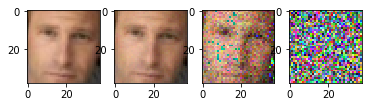

In [24]:
plt.subplot(1,4,1)
plt.imshow(X[0])
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.01)[0])
plt.subplot(1,4,3)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.1)[0])
plt.subplot(1,4,4)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.5)[0])

In [25]:
encoder,decoder = build_deep_autoencoder(img_shape,code_size=512)
assert encoder.output_shape[1:]==(512,), "encoder must output a code of required size"

inp = L.Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp,reconstruction)
autoencoder.compile('adamax','mse')

In [ ]:
for i in range(50):
    print("Epoch %i/50, Generating corrupted samples..."%i)
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)
    
    autoencoder.fit(x=X_train_noise,y=X_train,epochs=1,
                    validation_data=[X_test_noise,X_test])

__Note:__ if it hasn't yet converged, increase the number of iterations.

__Bonus:__ replace gaussian noise with masking random rectangles on image.

In [ ]:
denoising_mse = autoencoder.evaluate(apply_gaussian_noise(X_test),X_test,verbose=0)
print("Final MSE:", denoising_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [ ]:
encoder.save("./encoder.h5")
decoder.save("./decoder.h5")

### Submit to Coursera

In [ ]:
from submit import submit_autoencoder
submission = build_deep_autoencoder(img_shape,code_size=71)
submit_autoencoder(submission, reconstruction_mse, 2<email>, <token>)

### Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see it in action.

First thing we can do is image retrieval aka image search. We we give it an image and find similar images in latent space. 

To speed up retrieval process, we shall use Locality-Sensitive Hashing on top of encoded vectors. We'll use scikit-learn's implementation for simplicity. In practical scenario, you may want to use [specialized libraries](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) for better performance and customization.

In [ ]:
images = X_train
codes = <encode all images>
assert len(codes) == len(images)

In [ ]:
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encoder.predict(image[None])
    
    (distances,),(idx,) = lshf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [ ]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image)
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
#smiles
show_similar(X_test[2])

In [ ]:
#ethnicity
show_similar(X_test[500])

In [ ]:
#glasses
show_similar(X_test[66])

## Bonus: cheap image morphing


In [ ]:

for _ in range(5):
    image1,image2 = X_test[np.random.randint(0,len(X_test),size=2)]

    code1, code2 = encoder.predict(np.stack([image1,image2]))

    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = code1*(1-a) + code2*(a)
        output_image = decoder.predict(output_code[None])[0]

        plt.subplot(1,7,i+1)
        plt.imshow(output_image)
        plt.title("a=%.2f"%a)
        
    plt.show()

Of course there's a lot more you can do with autoencoders.

If you want to generate images from scratch, however, we recommend you our honor track seminar about generative adversarial networks.